<a href="https://colab.research.google.com/github/stephanzwicknagl/ML2-Final/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras_tuner

     |████████████████████████████████| 133 kB 15.4 MB/s 


In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import keras_tuner as kt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix, fbeta_score, recall_score, precision_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(203)

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/creditcard.csv")


# Data Exploration and Preparation

In [4]:
# check for missing values
data.isnull().sum().any()

False

The data contains 28 anonymized numerical columns and time and amount. The target is the only categorical variable.

The data was collected over a period of 2 days. Normalize to 1 day and do a log transform on time and amount, because of how spread out the values are. Since some of them have value zero, we add a small value to them.

In [5]:
data["Time"] = data["Time"].apply(lambda x: x / 3600 % 24)
data['Amount'] = np.log(data['Amount'] + 0.00001)
data['Time'] = np.log(data['Time'] + 0.00001)
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-11.512925,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008099,0
1,-11.512925,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989545,0
2,-8.153322,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936639,0
3,-8.153322,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816241,0
4,-7.477702,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248353,0


Text(0, 0.5, 'Frequency')

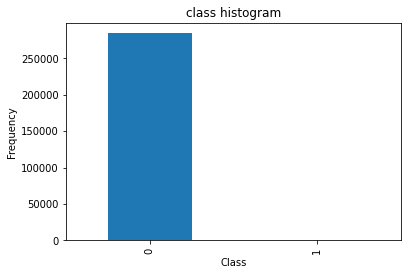

In [6]:
count_classes = data['Class'].value_counts()
count_classes.plot(kind='bar')
plt.title("class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")


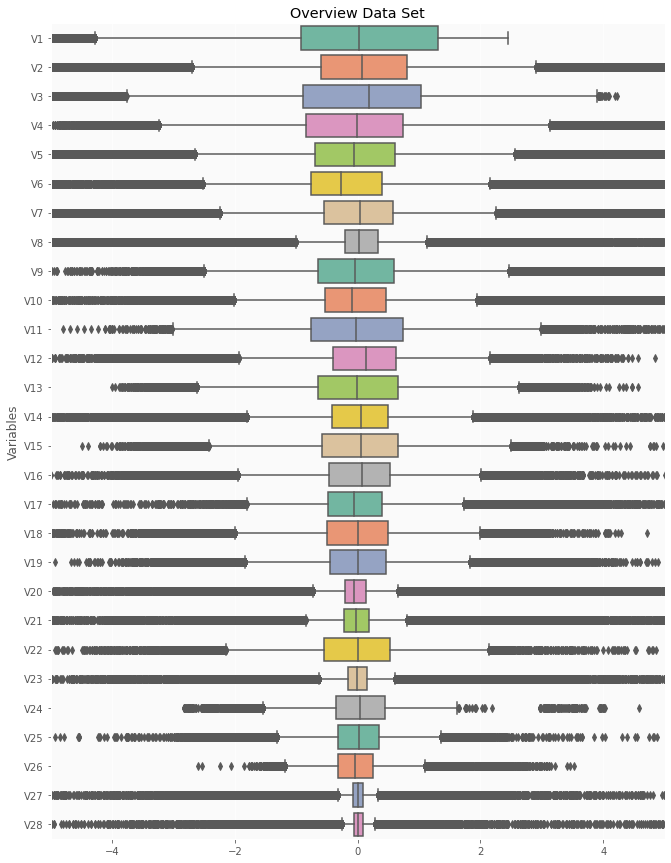

In [7]:
plt.style.use('ggplot')  # Using ggplot2 style visuals

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 5))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data=data.drop(columns=['Amount', 'Class', 'Time']),
                 orient='h',
                 palette='Set2')


In [8]:
# Split data and label
x = data.drop(["Class"], axis=1)
y = data["Class"].values

# scale data
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)

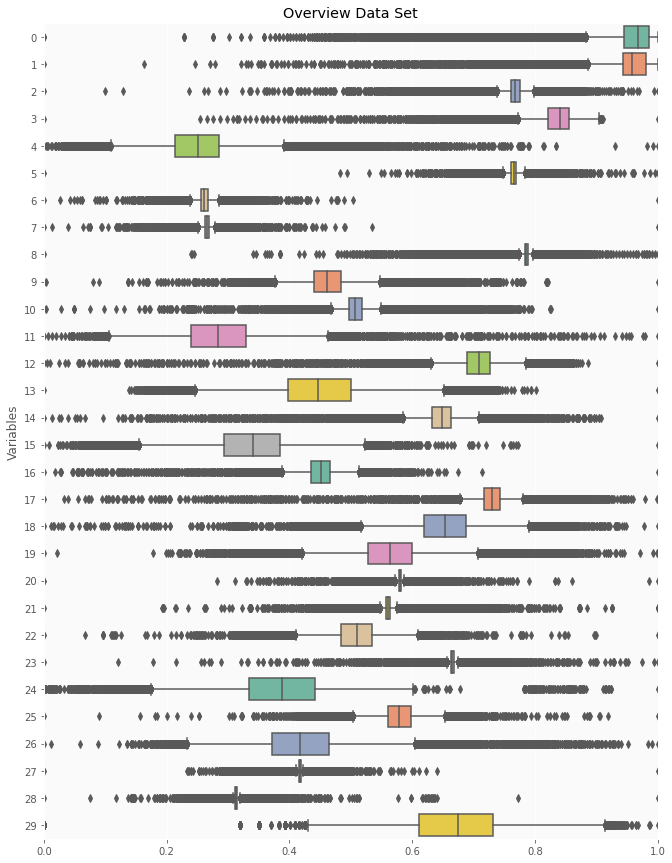

In [9]:
plt.style.use('ggplot')  # Using ggplot2 style visuals

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(0, 1))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data=x_scale,
                 orient='h',
                 palette='Set2')


### TSNE Vizualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


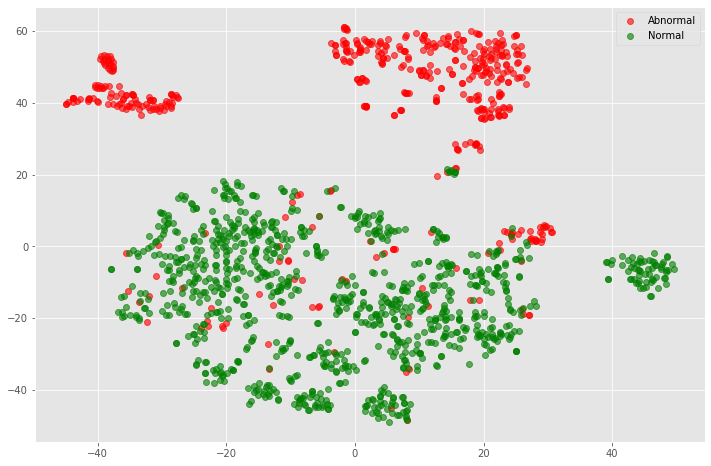

In [10]:
tsne = TSNE(n_components=2, random_state=123, init='random')
non_fraud = data[data['Class'] == 0].sample(1000, random_state=1233)
fraud = data[data['Class'] == 1]
df_tsne = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X_tsne = df_tsne.drop(['Class'], axis=1).values
Y_tsne = df_tsne["Class"].values
X_t = tsne.fit_transform(X_tsne)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y_tsne == 1), 0], X_t[np.where(Y_tsne == 1), 1], marker='o', color='r', linewidth=1, alpha=0.6, label='Abnormal')
plt.scatter(X_t[np.where(Y_tsne == 0), 0], X_t[np.where(Y_tsne == 0), 1], marker='o', color='g', linewidth=1, alpha=0.6, label='Normal')

plt.legend(loc='best');
plt.show();


# Linear

In [11]:
def k_fold_linear_classifier(X,Y,k=10,test_size=0.25,random_state=123, normalized=False):
    f2 = np.zeros(k)
    for i in range(k):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state+i)
        if normalized == False:
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        clf = LogisticRegression(penalty='none',max_iter=1000).fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        f2[i] = fbeta_score(Y_test, Y_pred, beta=2)
    print("F2 score:", f2.mean())
    return f2.mean()


In [12]:
score = k_fold_linear_classifier(x,y,k=1,test_size=0.25, random_state=123)
test_results = {}
test_results['Linear Model'] = score

F2 score: 0.6474820143884892


# PCA

In [13]:
def pca(X, numDims):
    #compute mean for each feature (columns)
    X_mean = X - np.mean(X, axis=0)

    #compute covariance matrix
    cov_mat = np.cov(X_mean, rowvar=False)  # each column represents a feature

    # find principal axes: compute eigenvectors, each eigenvector (column) corresponds to a principal component
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    #sort in descending order of the eigenvalue, so the first column captures the highest variance?
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]

    #slice eigenvectors: all rows, only 0- numDim columns (features)
    eigenvector_subset = sorted_eigenvectors[:, 0:numDims]

    #project data onto Ist numDims eigenvectors
    X_reduced = np.dot(eigenvector_subset.transpose(),
                       X_mean.transpose()).transpose()
    return X_reduced  # +np.mean(X, axis=0)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

In [15]:
# Tune PCA
def tune_pca(X, y):
  scores = {}
  for i in range(1, X.shape[1]):
    print("NumDims: {}".format(i))
    X_reduced = pca(X, numDims=i)
    scores['{}'.format(i)] = k_fold_linear_classifier(
        X_reduced, y, k=5, test_size=0.25, random_state=123, normalized=True)
  return scores
scores = tune_pca(x_train,y_train)

NumDims: 1
F2 score: 0.0
NumDims: 2
F2 score: 0.05410433438384308
NumDims: 3
F2 score: 0.12138216923594172
NumDims: 4
F2 score: 0.1806065122064365
NumDims: 5
F2 score: 0.32204173186152063
NumDims: 6
F2 score: 0.3302432185257683
NumDims: 7
F2 score: 0.3359608926885851
NumDims: 8
F2 score: 0.3977194006674466
NumDims: 9
F2 score: 0.40115099179228253
NumDims: 10
F2 score: 0.3943499244108096
NumDims: 11
F2 score: 0.5079379053680941
NumDims: 12
F2 score: 0.5166992164534525
NumDims: 13
F2 score: 0.5137591786067177
NumDims: 14
F2 score: 0.5505866898624778
NumDims: 15
F2 score: 0.6036949632402356
NumDims: 16
F2 score: 0.6015302545515839
NumDims: 17
F2 score: 0.6256962133242258
NumDims: 18
F2 score: 0.6259349668311814
NumDims: 19
F2 score: 0.6279294009684728
NumDims: 20
F2 score: 0.6282286528387969
NumDims: 21
F2 score: 0.631036805885701
NumDims: 22
F2 score: 0.6307434432161008
NumDims: 23
F2 score: 0.6339137858426371
NumDims: 24
F2 score: 0.6421465317474202
NumDims: 25
F2 score: 0.6486770090072

In [16]:
# highest F2 score in scores
max_f2_dims = max(scores, key=scores.get)

In [17]:
X_reduced = pca(x_test, numDims=int(max_f2_dims))
score = k_fold_linear_classifier(X_reduced, y_test, k=10, test_size=0.25, random_state=123, normalized=True)
test_results['PCA'] = score

F2 score: 0.6638956211261807


# Cluster

In [18]:
normal = data[data["Class"] == 0]
abnorm = data[data["Class"] == 1]

x_normal = normal.iloc[:, :-1]
y_normal = normal.iloc[:, -1]

x_abnorm = abnorm.iloc[:, :-1]
y_abnorm = abnorm.iloc[:, -1]

# 50% of normal to train
train, normal_test, _,_ = train_test_split(normal, normal, test_size=0.5, random_state=123)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=0.5, random_state=123)

abnorm_valid, abnorm_test, _,_ = train_test_split(abnorm, abnorm, test_size=0.5, random_state=123)

x_train=  train.iloc[:, :-1]
x_train = x_train.reset_index(drop=True)

valid = pd.concat([normal_valid, abnorm_valid]).sample(frac=1).reset_index(drop=True)
x_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

test  = pd.concat([normal_test, abnorm_test]).sample(frac=1).reset_index(drop=True)
x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [19]:
# configure our pipeline
pipeline = Pipeline([#('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
# get normalization parameters by fitting to the training data
pipeline.fit(x_train)
# apply transformation to the training, validation and test data
x_train_scale = pipeline.transform(x_train)
x_valid_scale = pipeline.transform(x_valid)
x_test_scale = pipeline.transform(x_test)


In [20]:
def tune_gmm(start=2,end=5):
    scores = {}
    best_thresholds = {}
    for i in range(start, end):
        gmm = GaussianMixture(n_components=i, n_init=4)
        gmm.fit(x_train)

        min = gmm.score(x_valid[y_valid == 0])
        max = gmm.score(x_valid[y_valid == 1])

        y_scores = gmm.score_samples(x_valid)

        thresholds = np.linspace(min, max, 100)

        f1, f2, recall, precision= [], [],[],[]
        for threshold in thresholds:
            y_pred = (y_scores < threshold).astype(int)
            f1.append(f1_score(y_valid, y_pred))
            f2.append(fbeta_score(y_valid, y_pred, beta=2))
            recall.append(recall_score(y_valid, y_pred))
            precision.append(precision_score(y_valid, y_pred))

        f1 = np.array(f1)
        f2 = np.array(f2)
        recall = np.array(recall)
        precision = np.array(precision)
        print("Clusters: {}".format(i))
        print("Best score: {}".format(f2.max()))
        print("For threshold: {}".format(thresholds[f2.argmax()]))
        print("")
        scores['{}'.format(i)] = f2.max()
        best_thresholds['{}'.format(i)] = thresholds[f2.argmax()]
    
    return scores, best_thresholds

In [21]:
scores, best_thresholds = tune_gmm()

Clusters: 2
Best score: 0.6563845050215209
For threshold: -155.80698578589218

Clusters: 3
Best score: 0.6344307270233197
For threshold: -86.9982500783175

Clusters: 4
Best score: 0.5857253685027153
For threshold: -78.21592351801101



In [22]:
# highest F2 score in scores
max_f2_cluster = max(scores, key=scores.get)
max_f2_threshold = best_thresholds[max_f2_cluster]
print("Best number for clusters: {}".format(max_f2_cluster))
print("With best threshold: {}".format(max_f2_threshold))

Best number for clusters: 2
With best threshold: -155.80698578589218


In [23]:
gmm = GaussianMixture(n_components=int(max_f2_cluster), n_init=4)
gmm.fit(x_train)
y_scores = gmm.score_samples(x_test)
y_pred = (y_scores < max_f2_threshold).astype(int)
score = fbeta_score(y_test, y_pred, beta=2)
test_results['GMM'] = score
print(score)

0.7092696629213483


# Autoencoder

In [24]:
def build_model(hp):
    activation1 = 'tanh' #hp.Choice('activation1', ['tanh', 'sigmoid'])
    n_hidden1 = 60 #hp.Int('n_hidden1', min_value=31, max_value=100)
    n_hidden2 = 30 #hp.Int('n_hidden2', min_value=8, max_value=n_hidden1)
    n_hidden3 = 8


    ## input layer
    input_layer = Input(shape=(x_normal.shape[1],))

    ## encoding part
    encoded = Dense(n_hidden1, activation=activation1)(input_layer)
    encoded = Dense(n_hidden2, activation=activation1)(input_layer)
    encoded = Dense(n_hidden3, activation=activation1)(encoded)

    ## decoding part
    # decoded = Dense(n_hidden3, activation=activation1)(encoded)
    decoded = Dense(n_hidden2, activation=activation1)(encoded)
    decoded = Dense(n_hidden1, activation=activation1)(decoded)

    ## output layer
    output_layer = Dense(x_normal.shape[1], activation=activation1)(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
    return autoencoder


In [25]:
tuner = kt.Hyperband(
    build_model,
    objective='loss')


In [26]:
#tuner.search(x_train_scale, x_train_scale, epochs=10)
#autoencoder = tuner.get_best_models()[0]
# best tuned model
# activation1 tanh
# n_hidden1 60
# n_hidden2 30

In [27]:
autoencoder = build_model(1)
autoencoder.fit(x_train_scale, x_train_scale, epochs=100)

Epoch 1/100
4443/4443 [==============================] - 13s 3ms/step - loss: 0.0023 - accuracy: 0.5399
Epoch 2/100
4443/4443 [==============================] - 21s 5ms/step - loss: 7.5179e-04 - accuracy: 0.5882
Epoch 3/100
4443/4443 [==============================] - 10s 2ms/step - loss: 6.9409e-04 - accuracy: 0.6186
Epoch 4/100
4443/4443 [==============================] - 9s 2ms/step - loss: 6.6361e-04 - accuracy: 0.6207
Epoch 5/100
4443/4443 [==============================] - 9s 2ms/step - loss: 6.4722e-04 - accuracy: 0.6275
Epoch 6/100
4443/4443 [==============================] - 9s 2ms/step - loss: 6.3162e-04 - accuracy: 0.6358
Epoch 7/100
4443/4443 [==============================] - 9s 2ms/step - loss: 6.1975e-04 - accuracy: 0.6353
Epoch 8/100
4443/4443 [==============================] - 9s 2ms/step - loss: 6.1155e-04 - accuracy: 0.6359
Epoch 9/100
4443/4443 [==============================] - 10s 2ms/step - loss: 6.0467e-04 - accuracy: 0.6357
Epoch 10/100
4443/4443 [=============

In [28]:
# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(x_valid_scale)
# calculating the mean squared error reconstruction loss per row
mse = np.mean(np.power(x_valid_scale - reconstructions, 2), axis=1)


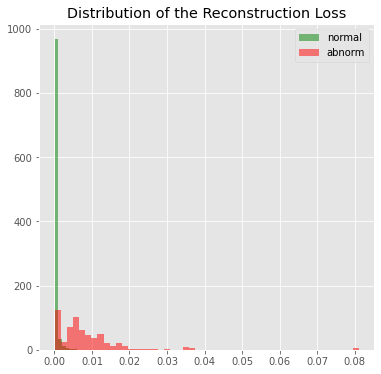

In [29]:
normal = mse[y_valid == 0]
abnorm = mse[y_valid == 1]

fig, ax = plt.subplots(figsize=(6, 6))

ax.hist(normal, bins=50, density=True, label="normal", alpha=.5, color="green")
ax.hist(abnorm, bins=50, density=True, label="abnorm", alpha=.5, color="red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


In [30]:
thresholds = np.linspace(mse.min(), mse.max(), 1000)

f2 = []
for threshold in thresholds:

    y_pred = [1 if p > threshold else 0 for p in mse]
    f2.append(fbeta_score(y_valid, y_pred, beta=2))

f2 = np.array(f2)
print("Best score: {}".format(f2.max()))
print("For threshold: {}".format(thresholds[f2.argmax()]))


Best score: 0.6033874382498235
For threshold: 0.004648815639732014


In [31]:
# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(x_test_scale)
# calculating the mean squared error reconstruction loss per row
mse = np.mean(np.power(x_test_scale - reconstructions, 2), axis=1)
y_pred = [1 if p > thresholds[f2.argmax()] else 0 for p in mse]
test_results['Autoencoder'] = fbeta_score(y_test, y_pred, beta=2)
print(test_results)

{'Linear Model': 0.6474820143884892, 'PCA': 0.6638956211261807, 'GMM': 0.7092696629213483, 'Autoencoder': 0.5882352941176471}
